Imports

In [120]:
import requests, re, ast
import pandas as pd, numpy as np
from bs4 import BeautifulSoup
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib


Loading Model

In [121]:
# Input the brand and model you're predicting the price for and the PakWheels ad url
brand = "Toyota"
car = "Corolla"
url = "https://www.pakwheels.com/used-cars/toyota-corolla-1999-for-sale-in-islamabad-10488524"


model = joblib.load(f"models\{brand}_{car}_model.pkl")
mlb = joblib.load(f"models\{brand}_{car}_mlb.pkl")

Scrapping data

In [122]:
def scrape_ad(url):
    """Scrape a single ad page and return structured car data."""
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"❌ Failed to fetch {url}: {e}")
        return None

    soup = BeautifulSoup(r.text, "html.parser")

    # -----------------------------
    # JSON-LD block
    # -----------------------------
    scripts = soup.find_all("script", type="application/ld+json")
    data = None
    for script in scripts:
        try:
            parsed = json.loads(script.string.strip())
            if isinstance(parsed, dict) and (parsed.get("@type") == "Product" or "Product" in parsed.get("@type", [])):
                offers = parsed.get("offers", {})
                if isinstance(offers, dict) and offers.get("url") == url:  # match the correct ad
                    data = parsed
                    break
        except Exception:
            continue

    if not data:
        print(f"⚠️ JSON-LD not found on {url}")
        return None

    # Handle brand safely
    brand = data.get("brand")
    if isinstance(brand, dict):
        brand_name = brand.get("name", "")
    elif isinstance(brand, str):
        brand_name = brand
    else:
        brand_name = ""

    car_data = {
        "Name": data.get("name", ""),
        "City": data.get("name", "").split("for sale in")[-1].strip() if "for sale in" in data.get("name", "") else "",
        "Brand": brand_name,
        "Model": data.get("model", ""),
        "Year": data.get("modelDate", ""),
        "Mileage": data.get("mileageFromOdometer", ""),
        "Fuel": data.get("fuelType", ""),
        "Transmission": data.get("vehicleTransmission", ""),
        "Engine Capacity": data.get("vehicleEngine", {}).get("engineDisplacement", ""),
        "Color": data.get("color", ""),
        "Body Type": data.get("bodyType", ""),
        "Price": f"{data['offers'].get('price', '')} {data['offers'].get('priceCurrency', '')}" if "offers" in data else "",
        "Ad URL": data.get("offers", {}).get("url", ""),
        "Description": data.get("description", "")
    }

    # -----------------------------
    # Extra specs
    # -----------------------------
    specs_ul = soup.find("ul", id="scroll_car_detail")
    if specs_ul:
        spec_list = specs_ul.find_all("li")
        for i in range(0, len(spec_list), 2):
            key = spec_list[i].get_text(strip=True)
            val = spec_list[i + 1].get_text(strip=True)
            car_data[key] = val

    # -----------------------------
    # Features
    # -----------------------------
    features = soup.find("ul", class_="car-feature-list")
    if features:
        car_data["Features"] = [li.get_text(strip=True) for li in features.find_all("li")]
    else:
        car_data["Features"] = []

    # -----------------------------
    # Seller comments
    # -----------------------------
    comments_heading = soup.find("h2", id="scroll_seller_comments")
    if comments_heading:
        comments_div = comments_heading.find_next("div")
        car_data["Seller Comments"] = comments_div.get_text(separator=" ", strip=True)

    return car_data


car_data = scrape_ad(url)

Pre Processing

In [123]:
# Clean mileage (e.g. "52,000 km" -> 52000)
def clean_mileage(x):
    if pd.isna(x): return np.nan
    return int(re.sub(r"[^\d]", "", str(x))) if re.search(r"\d", str(x)) else np.nan

# Clean engine_cc (e.g. "796 cc" -> 796)
def clean_engine(x):
    if pd.isna(x): return np.nan
    return int(re.sub(r"[^\d]", "", str(x))) if re.search(r"\d", str(x)) else np.nan

# Clean price (e.g. "1,395,000 PKR" -> 1395000)
def clean_price(x):
    if pd.isna(x): return np.nan
    return int(re.sub(r"[^\d]", "", str(x))) if re.search(r"\d", str(x)) else np.nan


# Standardize colors
def clean_color(x):
    if pd.isna(x): return "Unknown"
    x = str(x).lower()
    if "silver" in x: return "Silver"
    if "white" in x: return "White"
    if "blue" in x: return "Blue"
    if "grey" in x or "gray" in x: return "Grey"
    if "black" in x: return "Black"
    return x.title()

In [124]:
# Clean mileage, engine, color etc
car_data["Mileage"] = clean_mileage(car_data.get("Mileage"))
car_data["Engine Capacity"] = clean_engine(car_data.get("Engine Capacity"))
car_data["Color"] = clean_color(car_data.get("Color"))
car_data["CarAge"] = 2025 - int(car_data.get("Year", 2025))
car_data["MileagePerYear"] = car_data["Mileage"] / max(car_data["CarAge"], 1)

# Features → binary
features_list = car_data.get("Features", [])
features_binary = mlb.transform([features_list])
features_df = pd.DataFrame(features_binary, columns=mlb.classes_)


In [125]:
X_input = pd.DataFrame([{
    "City": car_data.get("City","Unknown"),
    "Mileage": car_data["Mileage"],
    "Fuel": car_data.get("Fuel","Unknown"),
    "Transmission": car_data.get("Transmission","Unknown"),
    "Engine Capacity": car_data["Engine Capacity"],
    "Color": car_data.get("Color","Unknown"),
    "CarAge": car_data["CarAge"],
    "Registered In": car_data.get("Registered In", "Unknown"),
    "Assembly": car_data.get("Assembly", "Unknown")
}])

# Add binary features
X_input = pd.concat([X_input, features_df], axis=1)


Prediction

In [126]:
predicted_price = model.predict(X_input)[0]
print(f"Predicted Price: {predicted_price:,.0f} PKR")

if car_data.get("Price"):
    actual_price = clean_price(car_data["Price"])
    error = predicted_price - actual_price
    pct_error = error / actual_price * 100
    print(f"Actual Price: {actual_price:,.0f} PKR")
    print(f"Error: {error:,.0f} PKR ({pct_error:.2f}%)")


Predicted Price: 1,451,600 PKR
Actual Price: 1,410,000 PKR
Error: 41,600 PKR (2.95%)


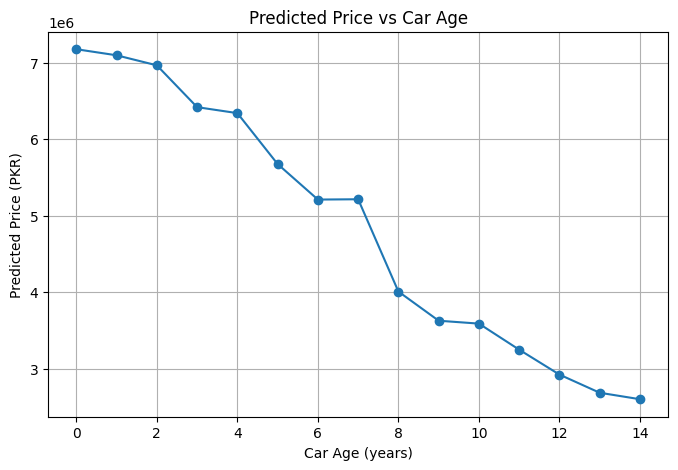

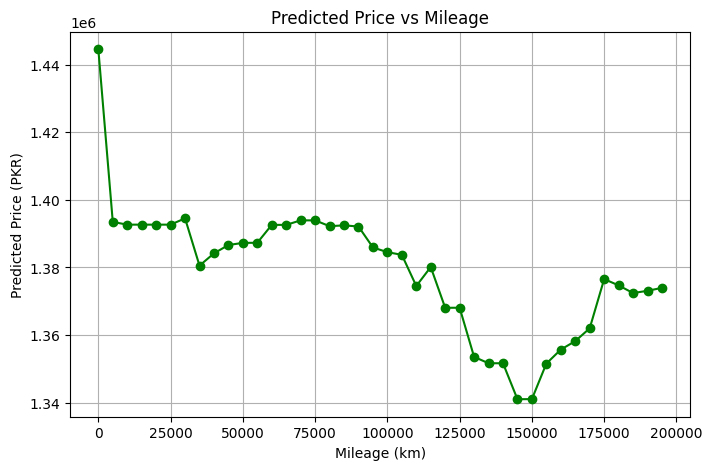

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose a range of CarAge values
car_age_range = np.arange(0, 15, 1)  # 0 to 14 years

predicted_prices = []

for age in car_age_range:
    X_temp = pd.DataFrame([{
        "City": car_data.get("City", "Unknown"),
        "Mileage": car_data["Mileage"],  # constant
        "Fuel": car_data.get("Fuel", "Unknown"),
        "Transmission": car_data.get("Transmission", "Unknown"),
        "Engine Capacity": car_data["Engine Capacity"],
        "Color": car_data.get("Color", "Unknown"),
        "CarAge": age,
        "Registered In": car_data.get("Registered In", "Unknown"),
        "Assembly": car_data.get("Assembly", "Unknown")
    }])

    # Add binary features
    X_temp = pd.concat([X_temp, features_df], axis=1)

    price = model.predict(X_temp)[0]
    predicted_prices.append(price)

# Plot
plt.figure(figsize=(8,5))
plt.plot(car_age_range, predicted_prices, marker='o')
plt.xlabel("Car Age (years)")
plt.ylabel("Predicted Price (PKR)")
plt.title("Predicted Price vs Car Age")
plt.grid(True)
plt.show()

# Choose a range of Mileage values
mileage_range = np.arange(0, 200000, 5000)  # 0 to 200,000 km in steps of 5k

predicted_prices = []

for mileage in mileage_range:
    X_temp = pd.DataFrame([{
        "City": car_data.get("City", "Unknown"),
        "Mileage": mileage,
        "Fuel": car_data.get("Fuel", "Unknown"),
        "Transmission": car_data.get("Transmission", "Unknown"),
        "Engine Capacity": car_data["Engine Capacity"],
        "Color": car_data.get("Color", "Unknown"),
        "CarAge": car_data["CarAge"],  # constant
        "Registered In": car_data.get("Registered In", "Unknown"),
        "Assembly": car_data.get("Assembly", "Unknown")
    }])

    X_temp = pd.concat([X_temp, features_df], axis=1)

    price = model.predict(X_temp)[0]
    predicted_prices.append(price)

# Plot
plt.figure(figsize=(8,5))
plt.plot(mileage_range, predicted_prices, marker='o', color='green')
plt.xlabel("Mileage (km)")
plt.ylabel("Predicted Price (PKR)")
plt.title("Predicted Price vs Mileage")
plt.grid(True)
plt.show()

